In [1]:
from stable_diffusion_pytorch import model_loader, pipeline
from stable_diffusion_pytorch.samplers.k_lms import KLMSSampler
from stable_diffusion_pytorch.tokenizer import Tokenizer
import stable_diffusion_pytorch.util as util
from PIL import Image
from IPython.display import display
from tqdm import tqdm
import torch, sys

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [3]:
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Device: ", device)

Python:  3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
PyTorch:  1.13.0+cpu
Device:  cpu


In [4]:
prompt = "An photo of an astronaut riding a horse."
prompts = [prompt]

uncond_prompt = ""
uncond_prompts = [uncond_prompt] if uncond_prompt else None
uncond_prompts = uncond_prompts or [""] * len(prompts)
input_images = []
strength = 0.8
do_cfg = True
cfg_scale = 7.5
height = 512
width = 512
n_inference_steps = 30
seed = 42
use_jit = False
export = True and not use_jit

In [5]:
if use_jit:
    models = dict()
    for name in ['clip', 'decoder', 'diffusion']:
        models[name] = torch.jit.load(f"models/{name}.pt")
        models[name].eval()
else:
    torch.jit.enable_onednn_fusion(True)
    models = model_loader.preload_models(device)

In [6]:
with torch.no_grad():
    tokenizer = Tokenizer()
    generator = torch.Generator(device='cpu')
    generator.manual_seed(seed)
    tokens = tokenizer.encode_batch(prompts)
    tokens = torch.tensor(tokens, dtype=torch.long, device=device)
    cond_context = models['clip'](tokens)
    uncond_tokens = tokenizer.encode_batch(uncond_prompts or [""] * len(prompts))
    uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
    uncond_context = models['clip'](uncond_tokens)
    context = torch.cat([cond_context, uncond_context])

    if export:
        with torch.jit.optimized_execution(True):
            clip_traced = torch.jit.trace(models['clip'], tokens)
            clip_traced.eval()
            clip_traced = torch.jit.freeze(clip_traced)
        clip_traced.save("models/clip.pt")
        del clip_traced

In [7]:
context.shape

torch.Size([2, 77, 768])

In [8]:
with torch.no_grad():
    sampler = KLMSSampler(n_inference_steps=n_inference_steps)
    noise_shape = (len(prompts), 4, height // 8, width // 8)
    latents = torch.randn(noise_shape, generator=generator, device=device)
    latents *= sampler.initial_scale

In [9]:
latents.shape

torch.Size([1, 4, 64, 64])

In [10]:
sampler.timesteps

array([999.        , 964.55172414, 930.10344828, 895.65517241,
       861.20689655, 826.75862069, 792.31034483, 757.86206897,
       723.4137931 , 688.96551724, 654.51724138, 620.06896552,
       585.62068966, 551.17241379, 516.72413793, 482.27586207,
       447.82758621, 413.37931034, 378.93103448, 344.48275862,
       310.03448276, 275.5862069 , 241.13793103, 206.68965517,
       172.24137931, 137.79310345, 103.34482759,  68.89655172,
        34.44827586,   0.        ])

In [11]:
sampler.sigmas

array([14.61465739, 11.91752244,  9.81416826,  8.15844756,  6.84304845,
        5.78854692,  4.93564045,  4.23970101,  3.6668879 ,  3.19133468,
        2.79314373,  2.4568825 ,  2.17051669,  1.92458661,  1.71161638,
        1.52565169,  1.36192268,  1.21657782,  1.08648283,  0.9690621 ,
        0.8621744 ,  0.76400646,  0.67298457,  0.58768333,  0.50672418,
        0.42861852,  0.35146718,  0.27218293,  0.18345095,  0.02916754,
        0.        ])

In [12]:
with torch.no_grad():
    timesteps = tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
        time_embedding = util.get_time_embedding(timestep).to(device)
        input_latents = latents * sampler.get_input_scale()
        if do_cfg:
            input_latents = input_latents.repeat(2, 1, 1, 1)
        output = models['diffusion'](input_latents, context, time_embedding)
        if export and i == 0:
            with torch.jit.optimized_execution(True):
                diffusion_traced = torch.jit.trace(models['diffusion'], (input_latents, context, time_embedding))
                diffusion_traced.eval()
                diffusion_traced = torch.jit.freeze(diffusion_traced)
            diffusion_traced.save("models/diffusion.pt")
            del diffusion_traced
        if do_cfg:
            output_cond, output_uncond = output.chunk(2)
            output = cfg_scale * (output_cond - output_uncond) + output_uncond
        latents = sampler.step(latents, output)

100%|██████████| 30/30 [11:05<00:00, 22.18s/it]  


In [13]:
output.shape

torch.Size([1, 4, 64, 64])

In [14]:
latents.shape

torch.Size([1, 4, 64, 64])

In [15]:
with torch.no_grad():
    images = models['decoder'](latents)
    images = util.rescale(images, (-1, 1), (0, 255), clamp=True)
    images = util.move_channel(images, to="last")
    images = images.to('cpu', torch.uint8).numpy()
    results = [Image.fromarray(image) for image in images]
    if export:
        with torch.jit.optimized_execution(True):
            decoder_traced = torch.jit.trace(models['decoder'], latents)
            decoder_traced.eval()
            decoder_traced = torch.jit.freeze(decoder_traced)
        decoder_traced.save("models/decoder.pt")
        del decoder_traced

In [16]:
images[0].shape

(512, 512, 3)

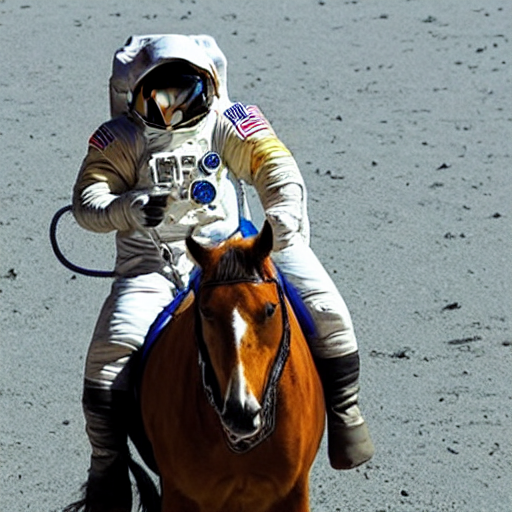

In [17]:
for image in results:
    display(image)